In [ ]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis

# import margin from westpac website
import tabula
import pandas as pd
myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
#df2.loc[:,'ASX Code']=df2['ASX Code'] + '.AX'


a = pd.read_csv('margin.csv')
df = pd.merge(a,df2,on='ASX Code',how='left')
df = df.drop(['LVR_x','Security Name_x'],axis=1)
df = df.rename(columns={'Security Name_y':'Security Name','LVR_y':'LVR'})
df = df[['ASX Code','Security Name','LVR','Industry','Valuation']]
df = df.dropna(subset=['Security Name'])


# convert string % to numeric %
df['LVR'] = df['LVR'].apply(lambda x:x.strip('%'))
df['LVR'] = pd.to_numeric(df['LVR'])/100


#df = df.style.set_properties(**{'text-align': 'left'})

df.to_csv('margin.csv')

In [3]:
from IPython.display import display
import pandas as pd


#print("Enter Your Date YYYY-MM-DD ")
mydate = '2021-02-17'
mydate = pd.to_datetime(mydate)


In [1]:
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format


# myfunction to use MACD to give signal


# 1. look at mac
# 2. look at overall market 

def MAC(MACD,Trigger,MACDiff,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    
    if MACD >= Trigger:   # logic for MACD > Trigger
        if MACD <= 0:     # below x axis (negative MACD) 
            action = 'Buy Confirm'
        elif MACD > 0:    # above x axis (positive MACD)  
            if MACDiff > 0:
                action = 'Hold'
            else:
                action = 'Time to Sell'
    elif MACD < Trigger:  # logic for MACD < Trigger
        if MACD <=0:      # below x axis (negative MACD)
            if MACDiff > 0:
                action = 'Buy Accumulate'
            elif Movement > 0 and Vol > 0:
                action = 'Market Buying'
            else:
                action = 'Time to Sell'
        elif MACD > 0:    # above x axis (positive MACD)
            if MACDiff > 0:
                action = 'Hold'
            elif Movement < 0 and Vol > 0:
                action = 'Market Selling'
            else:
                action = 'Time to Sell'
    else:
        action='Nothing'
            
    return action


# my purchase price table
myInput = pd.DataFrame({'Code':['AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [13.535,19.98,21.35],
                        'Unit': [4447,1275,163],
                        'InPortfolio':['y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details
mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
mystock = pd.read_csv(mycsv)

#mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock['ASX Code']:
    if i in ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")


# create columns for dataframe and the dataframe itself
mycol = []
mytbl = pd.DataFrame(columns=mycol)


# looping through the list to modify table
for i in mylist:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    df = data[i][['Close','Volume']]     # new one using Yfinance
    df['Code'] = i
    
    
############### avg 5 and 10 days
    ma_day = [5, 10]
    for ma in ma_day:
        column_name = f"Avg-{ma}days"
        df[column_name] = df['Close'].ewm(span=ma).mean()
    df['Mov-3Days'] = df['Close'].diff(3)
    df['MACD'] = df.iloc[:,3] - df.iloc[:,4]    # column 5 - columns 4 (Long - Short Avg)    
    df['Trigger'] = df.MACD.rolling(window=3).mean()
    df['MACD_Diff'] = df['MACD'].diff(1)
    df['Vol_Diff'] = df['Volume'].diff(1)
    df['Advice'] = df.apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)
    mytbl = mytbl.append(df)
################    


# Tidy Up the table by dropping null values for close
mytbl = mytbl.dropna(subset=['Close'])
mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})






# create multiple dataframes to make it easy to drill down . E.g just type AGL, WPL etc
for x,y,z in zip(mystock['ASX Code'],mylist,mystock['Security Name']):
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    vars()[x] = data[y][['Close','Volume']]     # new one using Yfinance
    
    df['Code'] = i
    
    
############### avg 5 and 10 days
    ma_day = [5, 10]
    for ma in ma_day:
        column_name = f"Avg-{ma}days"
        vars()[x][column_name] = vars()[x]['Close'].ewm(span=ma).mean()
    vars()[x]['Mov-3Days'] = vars()[x]['Close'].diff(1)
    vars()[x]['MACD'] = vars()[x].iloc[:,2] - vars()[x].iloc[:,3]    # column 5 - columns 4 (Long - Short Avg)    
    vars()[x]['Trigger'] = vars()[x].MACD.rolling(window=3).mean()
    vars()[x]['MACD_Diff'] = vars()[x]['MACD'].diff(1)
    vars()[x]['Vol_Diff'] = vars()[x]['Volume'].diff(1)
    vars()[x]['Advice'] = vars()[x].apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)
    vars()[x]['Company Name'] = z
################    

    
    

[*********************100%***********************]  384 of 384 completed


In [8]:
from pandas import DataFrame


myval = [
    # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
   
    
    ['2020-10-15',mydate,0.75,'AGL.AX','Long Term',4447,13.55],
    ['2020-12-15',mydate,0.75,'AGL.AX','Short Term',775,12.885],
    ['2020-8-27',mydate,0.75,'IAG.AX','Long Term',6060,5.08],
    ['2020-12-04',mydate,0.75,'CSL.AX','Long Term',33,294.19], 
    ['2020-12-11',mydate,0.75,'CSL.AX','Long Term',68,292.025], 
    ['2020-12-21',mydate,0.75,'CSL.AX','Long Term',34,287.511], 
    ['2021-1-12' ,mydate,0.75,'CSL.AX','Short Term',54,274.11],     
    ['2020-8-26',mydate,0.75,'WPL.AX','Long Term',1275,19.98],
    ['2020-11-25',mydate,0.75,'WPL.AX','Long Term',427,23.36],
    ['2020-12-2',mydate,0.75,'WPL.AX','Long Term',224,22.24],
    ['2020-12-21',mydate,0.65,'TWE.AX','Long Term',607,9.38],
    ['2021-1-4',mydate,0.6,'LNK.AX','Long Term',1236,4.78]
    
     ]



myprofit = DataFrame (myval,columns=['PurchaseDate','CurrentDate','LVR','Code','Position','Unit','Price'])
mylist = myprofit['Code'].drop_duplicates().tolist()
myprofit['PurchaseDate'] = pd.to_datetime(myprofit['PurchaseDate'])
mydf = mytbl[(mytbl['Code'].isin(mylist)) & (mytbl['Date']==mydate)]


finalprofit = pd.merge(myprofit,mydf,on='Code',how='left')
finalprofit = finalprofit[['PurchaseDate', 'CurrentDate', 'Code', 'Position', 'Unit', 'Price',
       'Close',  'Avg-5days', 'Avg-10days', 
       'MACD', 'Trigger', 'MACD_Diff', 'Vol_Diff', 'Advice','LVR']]


### add more calculation
finalprofit['Capital'] = (finalprofit['Unit'] * finalprofit['Price']) 
finalprofit['Margin'] = (finalprofit['Unit'] * finalprofit['Price']) * (1-finalprofit['LVR'])
finalprofit['Profit'] = (finalprofit['Close'] - finalprofit['Price']) * finalprofit['Unit']
finalprofit['%'] = (finalprofit['Close'] - finalprofit['Price']) * finalprofit['Unit'] / finalprofit['Capital']
finalprofit['Days'] = finalprofit['CurrentDate'] - finalprofit['PurchaseDate']
finalprofit['Days'] = finalprofit['Days'].dt.days.astype('int16')
finalprofit['Interest'] = (finalprofit['Capital'] - finalprofit['Margin']) * 3.75/100 / 265 * finalprofit['Days']

finalprofit['NetProfit'] = finalprofit['Profit'] - finalprofit['Interest']
finalprofit['Net%'] = finalprofit['NetProfit']/finalprofit['Capital']
########################

colProfit = ['PurchaseDate', 'CurrentDate', 'Code', 'Position', 'Unit', 'Price',
       'Close', 'Advice', 'Capital', 'Margin', 'Profit', '%', 'Days',
       'Interest', 'NetProfit', 'Net%']

finalprofit[colProfit]



,PurchaseDate,CurrentDate,Code,Position,Unit,Price,Close,Advice,Capital,Margin,Profit,%,Days,Interest,NetProfit,Net%
0,2020-10-15,2021-02-17,AGL.AX,Long Term,4447,13.55,10.36,Time to Sell,"60,256.85","15,064.21","-14,185.93",-0.24,125,799.40,"-14,985.33",-0.25
1,2020-12-15,2021-02-17,AGL.AX,Short Term,775,12.88,10.36,Time to Sell,"9,985.88","2,496.47","-1,956.88",-0.20,64,67.83,"-2,024.70",-0.20
2,2020-08-27,2021-02-17,IAG.AX,Long Term,6060,5.08,5.14,Market Selling,"30,784.80","7,696.20",363.60,0.01,174,568.50,-204.90,-0.01
3,2020-12-04,2021-02-17,CSL.AX,Long Term,33,294.19,281.17,Time to Sell,"9,708.27","2,427.07",-429.66,-0.04,75,77.28,-506.94,-0.05
4,2020-12-11,2021-02-17,CSL.AX,Long Term,68,292.02,281.17,Time to Sell,"19,857.70","4,964.42",-738.14,-0.04,68,143.31,-881.45,-0.04
5,2020-12-21,2021-02-17,CSL.AX,Long Term,34,287.51,281.17,Time to Sell,"9,775.37","2,443.84",-215.59,-0.02,58,60.17,-275.77,-0.03
6,2021-01-12,2021-02-17,CSL.AX,Short Term,54,274.11,281.17,Time to Sell,"14,801.94","3,700.49",381.24,0.03,36,56.55,324.69,0.02
7,2020-08-26,2021-02-17,WPL.AX,Long Term,1275,19.98,25.96,Hold,"25,474.50","6,368.62","7,624.50",0.30,175,473.14,"7,151.36",0.28
8,2020-11-25,2021-02-17,WPL.AX,Long Term,427,23.36,25.96,Hold,"9,974.72","2,493.68","1,110.20",0.11,84,88.93,"1,021.27",0.10
9,2020-12-02,2021-02-17,WPL.AX,Long Term,224,22.24,25.96,Hold,"4,981.76","1,245.44",833.28,0.17,77,40.71,792.57,0.16


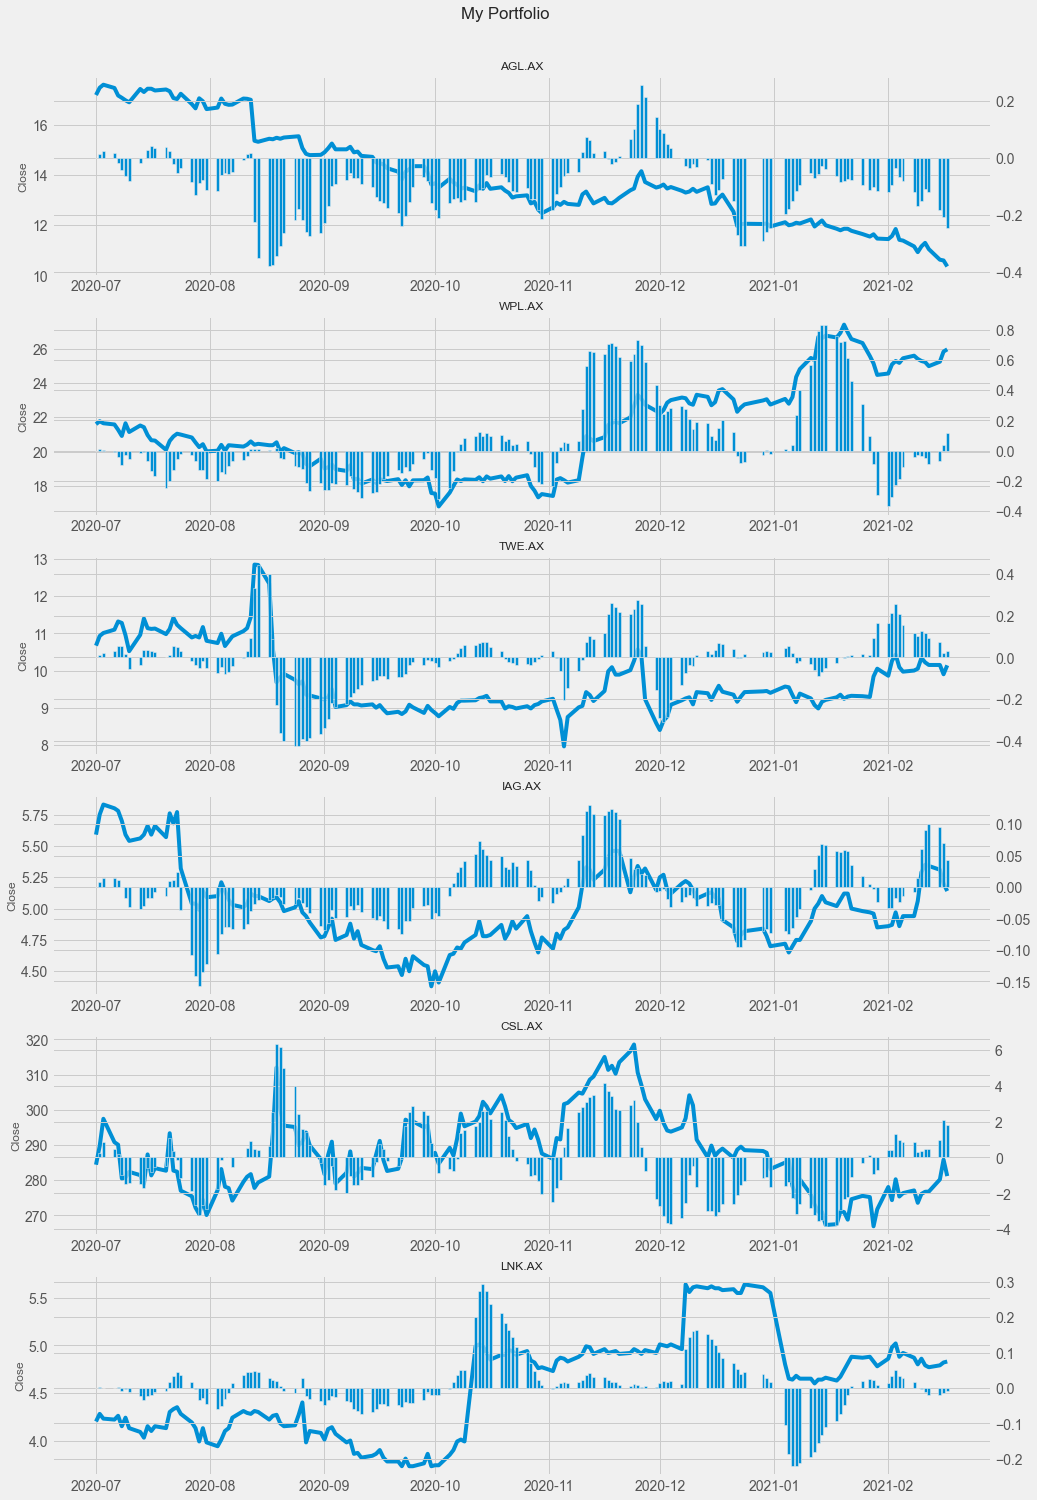

In [146]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['AGL.AX','WPL.AX','TWE.AX','IAG.AX','CSL.AX','LNK.AX']

fig, ax = plt.subplots(6,figsize=(15,24))

plt.suptitle('My Portfolio',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

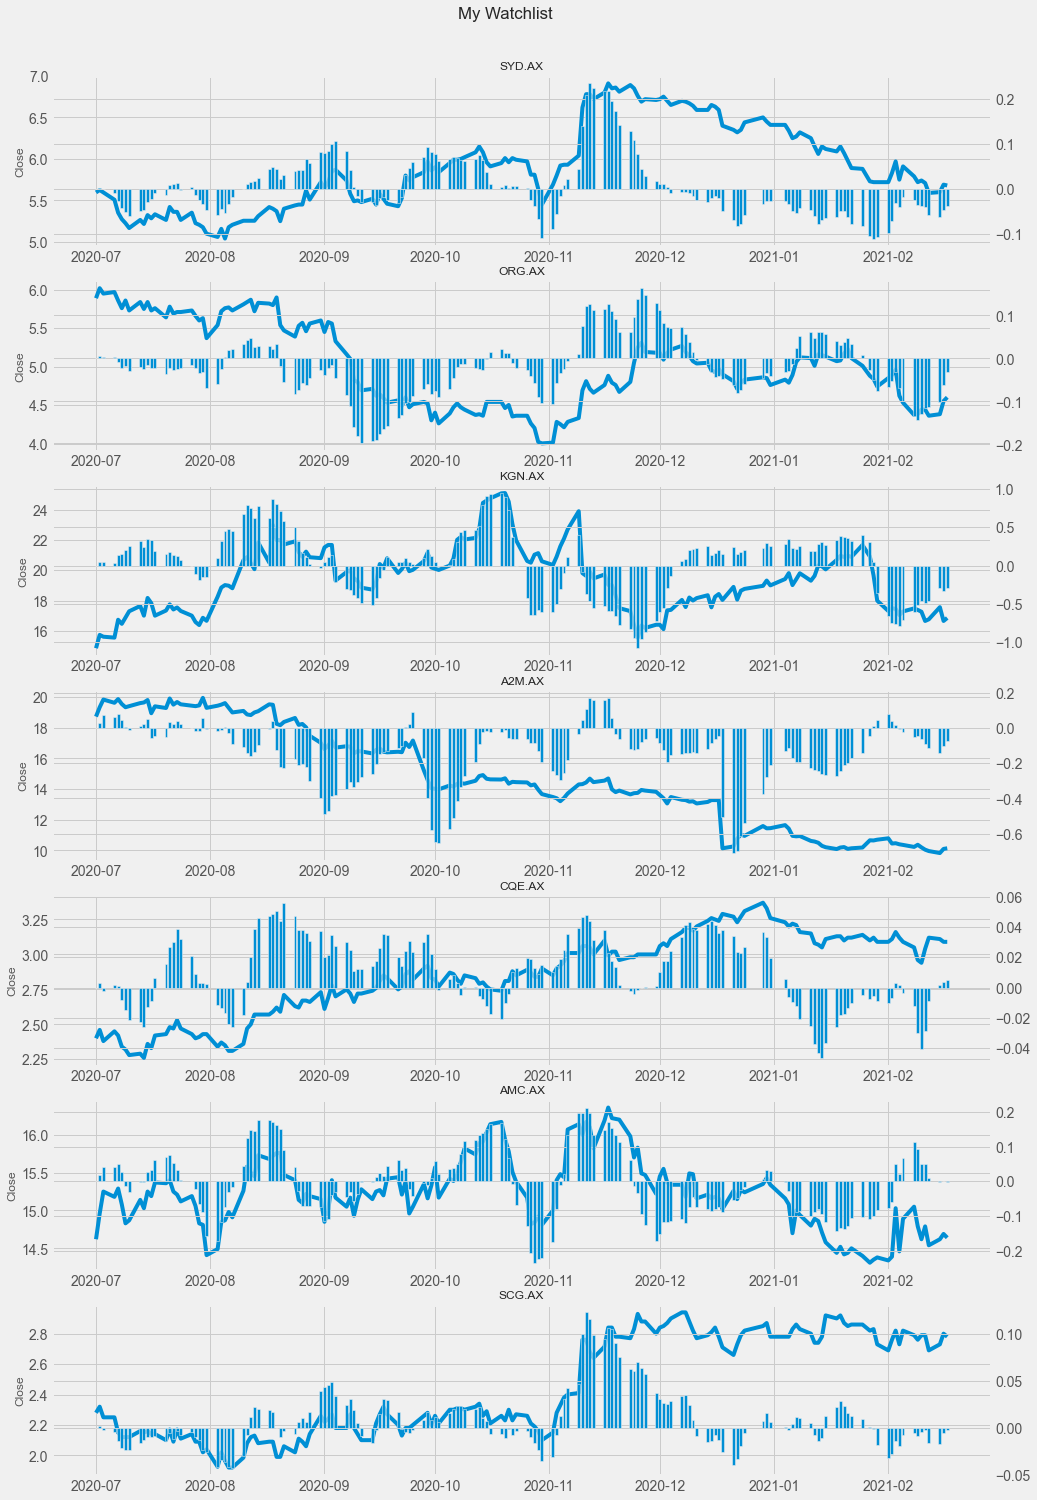

In [180]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['SYD.AX','ORG.AX','KGN.AX','A2M.AX','CQE.AX','AMC.AX','SCG.AX']

fig, ax = plt.subplots(7,figsize=(15,24))

plt.suptitle('My Watchlist',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

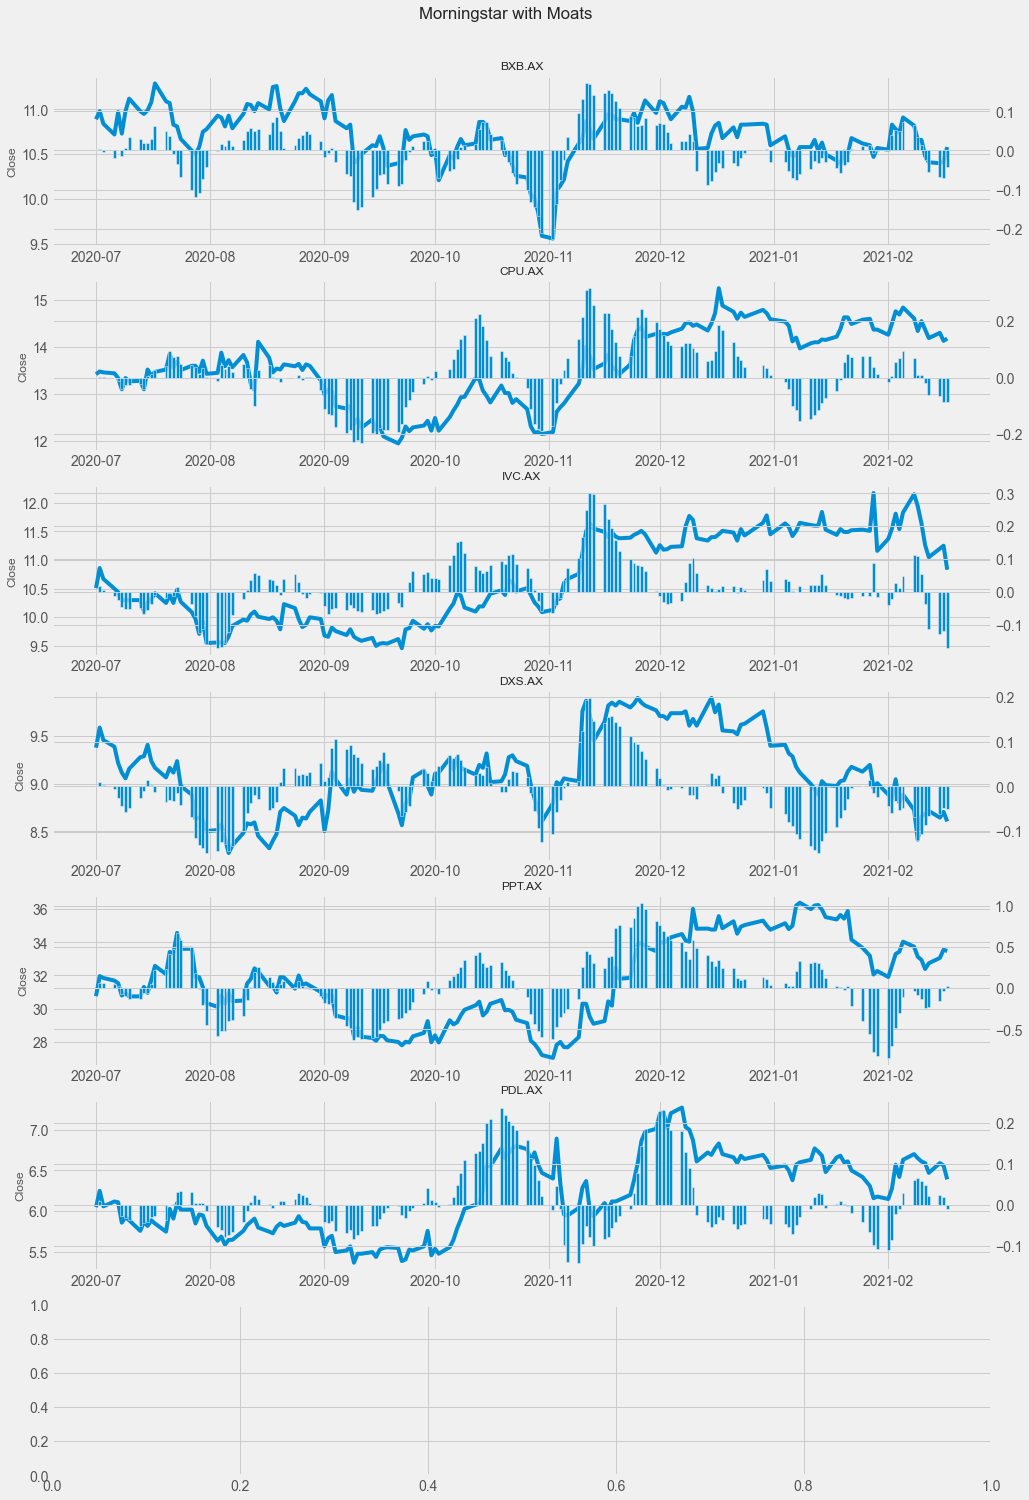

In [182]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['BXB.AX','CPU.AX','IVC.AX','DXS.AX','PPT.AX','PDL.AX']

fig, ax = plt.subplots(7,figsize=(15,24))

plt.suptitle('Morningstar with Moats',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

In [176]:
x = mytbl[(mytbl['Date'] > '2021-01-31') & (mytbl['Advice'].str.contains('Buying'))]
x.sort_values('Date')

,Date,Close,Volume,Code,Avg-5days,Avg-10days,Mov-3Days,MACD,Trigger,MACD_Diff,Vol_Diff,Advice
26365,2021-02-01,113.78,"6,467.00",IHCB.AX,113.92,113.99,0.11,-0.07,-0.05,-0.02,388.00,Market Buying
4846,2021-02-02,1.03,"360,846.00",APL.AX,1.08,1.09,0.00,-0.01,-0.01,-0.01,"360,846.00",Market Buying
55645,2021-02-04,55.23,"10,327.00",VDCO.AX,55.31,55.34,0.26,-0.03,-0.02,-0.02,"4,949.00",Market Buying
54034,2021-02-04,53.82,"36,153.00",VACF.AX,53.85,53.86,0.01,-0.01,-0.01,-0.01,"18,518.00",Market Buying
7437,2021-02-04,2.31,"527,426.00",AX1.AX,2.34,2.35,0.02,-0.01,-0.01,-0.00,"16,118.00",Market Buying
49343,2021-02-04,6.33,"177,293.00",SLK.AX,6.39,6.41,0.02,-0.02,-0.02,-0.01,"87,424.00",Market Buying
40124,2021-02-04,1.27,"131,452.00",PIA.AX,1.27,1.28,0.01,-0.00,-0.00,-0.00,"1,131.00",Market Buying
35915,2021-02-04,2.02,"446,301.00",NGI.AX,2.03,2.04,0.03,-0.01,-0.01,-0.00,"189,396.00",Market Buying
5985,2021-02-09,2.48,"1,338,933.00",ASB.AX,2.50,2.51,0.01,-0.01,-0.01,-0.00,"614,765.00",Market Buying
46917,2021-02-09,2.76,"23,671,251.00",SCG.AX,2.78,2.79,0.03,-0.01,-0.01,-0.00,"11,372,124.00",Market Buying


In [185]:
BXB[-20:]

,Close,Volume,Avg-5days,Avg-10days,Mov-3Days,MACD,Trigger,MACD_Diff,Vol_Diff,Advice,Company Name
Date,,,,,,,,,,,
2021-01-20,10.53,3130252,10.49,10.53,0.14,-0.04,-0.05,0.02,"-838,198.00",Buy Confirm,Brambles Limited
2021-01-21,10.50,4119252,10.50,10.53,-0.03,-0.03,-0.04,0.01,"989,000.00",Buy Confirm,Brambles Limited
2021-01-22,10.68,3880519,10.56,10.55,0.18,0.00,-0.02,0.03,"-238,733.00",Hold,Brambles Limited
2021-01-25,10.62,2282016,10.58,10.57,-0.06,0.01,-0.01,0.01,"-1,598,503.00",Hold,Brambles Limited
2021-01-27,10.60,4488093,10.59,10.57,-0.02,0.01,0.01,0.00,"2,206,077.00",Hold,Brambles Limited
2021-01-28,10.47,3270883,10.55,10.55,-0.13,-0.01,0.01,-0.02,"-1,217,210.00",Time to Sell,Brambles Limited
2021-01-29,10.57,4162616,10.55,10.56,0.10,-0.00,0.00,0.00,"891,733.00",Buy Accumulate,Brambles Limited
2021-02-01,10.55,2892231,10.55,10.56,-0.02,-0.00,-0.00,-0.00,"-1,270,385.00",Buy Confirm,Brambles Limited
2021-02-02,10.83,3419274,10.65,10.61,0.28,0.04,0.01,0.04,"527,043.00",Hold,Brambles Limited
